In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as img
from scipy.stats import probplot
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway

%matplotlib inline
%config InlineBackend.figure_format='svg'

In [2]:
df = pd.read_csv(r'C:\Users\Nick\Desktop\Dataset\DX_TEST_RESULT_FULL.csv')

In [3]:
grades = pd.read_csv(r'C:\Users\Nick\Desktop\Dataset\OpenPart.csv')

# Описание данных<br>

### DX_TEST_RESULT_FULL<br>
 * **file_name** - имя файла<br>
 * **user_name** - кто создавал разметку (*sample_1, sample_2, sample_3* - 3 ML-алгоритма,<br>
     *Expert* - разметка врача-эксперта)<br>
 * **xcenter, ycenter** - координаты центра фигуры, описывающей находку<br>
 * **rhorizontal, rvertical** - половина ширины и половина высоты области<br><br><br>
 
### OpenPart<br>
 * **Case** - имя файла<br>
 * **Sample 1, Sample 2, Sample 3** - оценки корректности соответствующего ML-алгоритма
 

# Первичный анализ данных

*Первое, что хочется посмотреть, есть ли пропуски в данных, надо ли что-то заполнять*

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   file_name     1067 non-null   object 
 1    user_name    1067 non-null   object 
 2    xcenter      1067 non-null   float64
 3    ycenter      1067 non-null   float64
 4    rhorizontal  1067 non-null   float64
 5    rvertical    1067 non-null   float64
 6    shape        1067 non-null   object 
 7   Unnamed: 7    3 non-null      object 
dtypes: float64(4), object(4)
memory usage: 66.8+ KB


*Пропуски есть в столбце 'Unnamed: 7'. Хорошо бы проверить какие значения в этом столбце.*

In [5]:
df['Unnamed: 7'].unique()

array([nan, ' '], dtype=object)

*В столбце 'Unnamed: 7' есть два типа значений - nan и пустая строка.<br>
На мой взгляд, этот столбец можно удалять*

In [6]:
df = df.drop(['Unnamed: 7'], axis=1)

*Удалим дубликаты*

In [7]:
df = df.drop_duplicates()

*Посмотрим статистическое описание каждого столбца*

In [8]:
df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

,xcenter,ycenter,rhorizontal,rvertical
count,1027.000000,1027.000000,1027.000000,1027.000000
mean,494.619469,503.008421,72.064275,76.256820
std,231.940566,152.128026,52.066632,68.809521
min,39.806971,69.319035,0.530570,0.000000
5%,185.994638,237.461986,18.039378,18.530831
25%,293.139896,403.508161,32.895337,29.512064
50%,413.313990,514.122280,54.906166,51.465285
75%,724.349167,621.126005,103.700361,93.645596
95%,831.862912,739.859157,159.288889,229.576408
max,918.991957,926.696833,376.035556,452.465116


*Выводы*:
* Я добавил два перцентиля (5% и 95%), чтобы лучше понять насколько тяжелые хвосты.<br>
    По ощущениям, у координат (xcenter, ycenter) хвосты не тяжелые, а у показателей<br>
    половины ширины и высоты - наоборот, тяжелые, особенно у rvertical.
* Странное значение у минимума rvertical - 0.0000.. Это либо ошибка, либо слишком<br>
    маленькая аномальная область. Настолько маленькая, что невозможно посчитать<br>
    половину ее высоты. Полоса или точка.

*Посмотрим насколько сбалансированны данные. Явно у каждого значения user_name разное количество объектов*

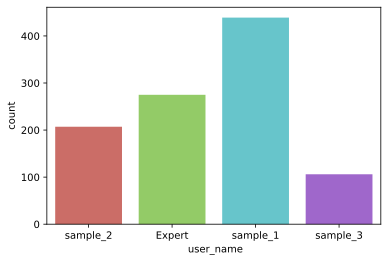

In [9]:
sns.countplot(x=' user_name', data=df, palette='hls')
plt.show()

*Смотрим несбалансированность в цифрах*<br>

In [10]:
df[' user_name'].unique()

array(['sample_2', 'Expert', 'sample_1', 'sample_3'], dtype=object)

In [11]:
sample_1 = len(df[df[' user_name']=='sample_1'])
sample_2 = len(df[df[' user_name']=='sample_2'])
sample_3 = len(df[df[' user_name']=='sample_3'])
expert = len(df[df[' user_name']=='Expert'])


perc_of_sample_1= sample_1/(sample_1+sample_2+sample_3+expert)
print("Percentage of Sample 1 is", perc_of_sample_1*100)

perc_of_sample_2 = sample_2/(sample_1+sample_2+sample_3+expert)
print("Percentage of Sample 2 is", perc_of_sample_2*100)

perc_of_sample_3 = sample_3/(sample_1+sample_2+sample_3+expert)
print("Percentage of Sample 3 is", perc_of_sample_3*100)

perc_of_expert = expert/(sample_1+sample_2+sample_3+expert)
print("Percentage of Expert   is", perc_of_expert*100)

Percentage of Sample 1 is 42.745861733203505
Percentage of Sample 2 is 20.155793573515094
Percentage of Sample 3 is 10.321324245374878
Percentage of Expert   is 26.777020447906523


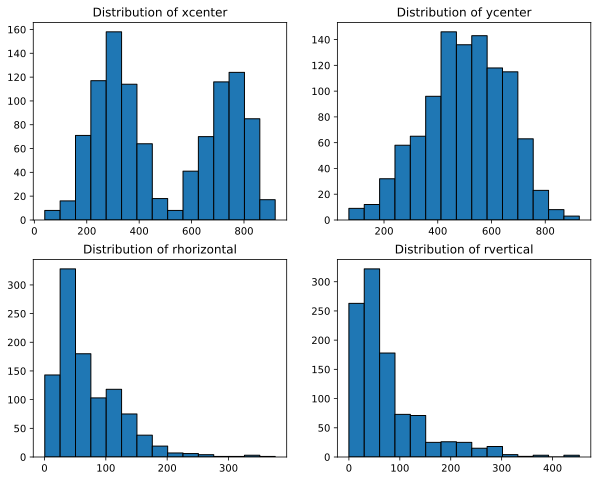

In [12]:
fig, ax=plt.subplots(nrows=2, ncols=2)
ax1, ax2, ax3, ax4 = ax.flatten()

ax1.hist(df[' xcenter'], bins=15, ec='black')
ax1.set_title('Distribution of xcenter')

ax2.hist(df[' ycenter'], bins=15, ec='black')
ax2.set_title('Distribution of ycenter')

ax3.hist(df[' rhorizontal'], bins=15, ec='black')
ax3.set_title('Distribution of rhorizontal')

ax4.hist(df[' rvertical'], bins=15, ec='black')
ax4.set_title('Distribution of rvertical')


fig.set_size_inches(10, 8)
plt.show()

*Выводы:*
* Посмотрите на расрпеделение x-координаты. Тут как-будто два распределения.<br> 
    Это связано с тем, что легкие - парный орган. Думаю, x-координата, разделяющая<br> 
    грудную клетку на правое и левое легкое, находится в районе 550.
* По расрпеделению x-координаты сложно судить о том, где чаще встречается аномальная область:<br>
    в правом или левом легком.
* Два четко выраженных пика также наводят на мысль, что данные у трех ML-алгоритмов и врача согласованны.<br>
    На первый взгляд критических расхождений в оценке аномальной области нет. Можно посмотреть<br>
    распределение по x-координате для каждого user_name и выявить расхождения.
* Распределение y-координаты говорит нам о тенденции расположения аномалий в центральной/верхней<br>
    части грудной клетки
* Опять же, распределение r_horizontal и r_vertical позволяет предположить, что большинство аномальных<br>
    областей относительно небольшого размера

*Выше показаны данные для всех user_name. Интересно посмотреть, какотличаются распределения<br>
x-координаты для каждой модели и врача*

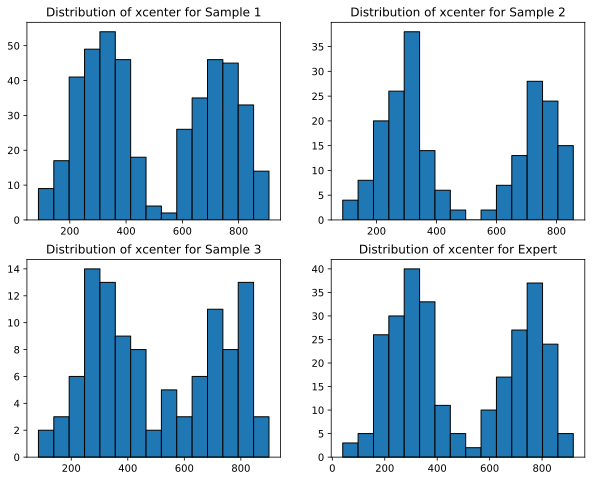

In [13]:
fig, ax=plt.subplots(nrows=2, ncols=2)
ax1, ax2, ax3, ax4 = ax.flatten()

ax1.hist(df.loc[df[' user_name'] == 'sample_1', ' xcenter'], bins=15, ec='black')
ax1.set_title('Distribution of xcenter for Sample 1')

ax2.hist(df.loc[df[' user_name'] == 'sample_2', ' xcenter'], bins=15, ec='black')
ax2.set_title('Distribution of xcenter for Sample 2')

ax3.hist(df.loc[df[' user_name'] == 'sample_3', ' xcenter'], bins=15, ec='black')
ax3.set_title('Distribution of xcenter for Sample 3')

ax4.hist(df.loc[df[' user_name'] == 'Expert', ' xcenter'], bins=15, ec='black')
ax4.set_title('Distribution of xcenter for Expert')


fig.set_size_inches(10, 8)
plt.show()

*Вывод*:
* У sample_1, sample_2 и Expert похожие распределения по столбцу xcenter. От них отличается sample_3.<br>
    Если бы это были не рентгенорвские снимки грудной клетки, то не было бы очевидным, является sample_3 <br>
    хорошей или плохой моделью. Просто у нее распределение x-координаты отличается от распределений <br>
    у врача и других двух моделей. Но мы смотрим легкие и должны увидеть провал в частоте <br>
    обнаружения аномалий, чего не видно на гистограмме для sample_3. Хотя, возможно дело в малом <br>
    количестве анализируемых рентгенограмм для sample_3.

*Далее хочу показать как распределены центры аномальных областей на реальном рентгеновском снимке.<br>
Я выбрал снимок, на котором легкие хорошо видны и занимают большую часть снимка. Я понимаю, что так <br>
делать некорректно (никто не отменял индивидуальные особенности), но для внутреннего понимания, мне <br>
кажется, допустимо.*

In [14]:
x_ray = img.imread(r'C:\Users\Nick\Desktop\Dataset\Origin\00018366_000.png')

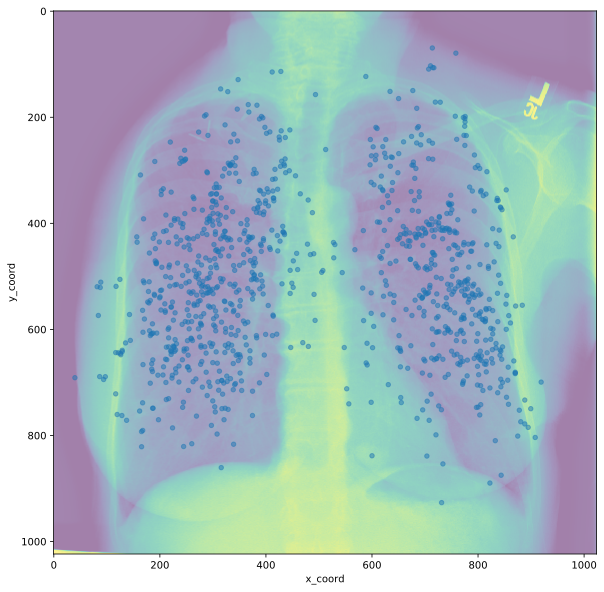

In [15]:
df.plot(kind='scatter', x=' xcenter', y=' ycenter', alpha=0.5,  
           figsize=(18,10))

plt.imshow(x_ray, alpha=0.5)

plt.xlabel("x_coord")
plt.ylabel("y_coord")
plt.show()

*Так же как и на гистограммах, на рисунке привел все значения всех моделей + эксперта <br>
Посмотрим как распределены точки у каждой модели и у эксперта. Это просто еще один вариант <br>
визуального представления данных (ранее было показано на гистограммах, сейчас на рентгенограмме).*

In [16]:
new_df = pd.DataFrame({'for_sample_1_x': df.loc[df[' user_name'] == 'sample_1', ' xcenter'], 
                       'for_sample_1_y': df.loc[df[' user_name'] == 'sample_1', ' ycenter'], 
                       'for_sample_2_x': df.loc[df[' user_name'] == 'sample_2', ' xcenter'], 
                       'for_sample_2_y': df.loc[df[' user_name'] == 'sample_2', ' ycenter'], 
                       'for_sample_3_x': df.loc[df[' user_name'] == 'sample_3', ' xcenter'], 
                       'for_sample_3_y': df.loc[df[' user_name'] == 'sample_3', ' ycenter'], 
                       'for_Expert_x': df.loc[df[' user_name'] == 'Expert', ' xcenter'], 
                       'for_Expert_y': df.loc[df[' user_name'] == 'Expert', ' ycenter']
                      })

#### Sample 1

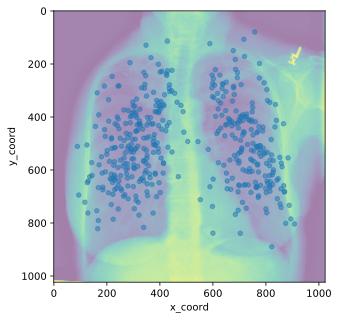

In [17]:
new_df.plot(kind='scatter', 
        x='for_sample_1_x', 
        y='for_sample_1_y', 
        alpha=0.5,  
        figsize=(12,5))

plt.imshow(x_ray, alpha=0.5)

plt.xlabel("x_coord")
plt.ylabel("y_coord")
plt.show()

#### Sample 2

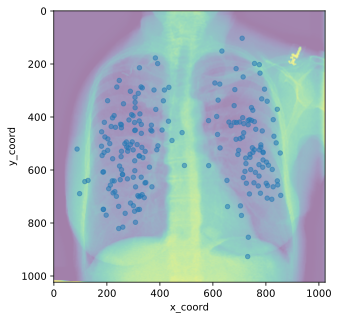

In [18]:
new_df.plot(kind='scatter', 
        x='for_sample_2_x', 
        y='for_sample_2_y', 
        alpha=0.5,  
        figsize=(12,5))

plt.imshow(x_ray, alpha=0.5)

plt.xlabel("x_coord")
plt.ylabel("y_coord")
plt.show()

#### Expert

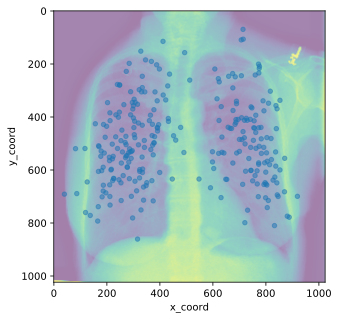

In [19]:
new_df.plot(kind='scatter', 
        x='for_Expert_x', 
        y='for_Expert_y', 
        alpha=0.5,  
        figsize=(12,5))

plt.imshow(x_ray, alpha=0.5)

plt.xlabel("x_coord")
plt.ylabel("y_coord")
plt.show()

#### Sample 3

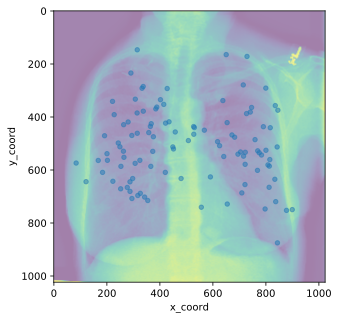

In [20]:
new_df.plot(kind='scatter', 
        x='for_sample_3_x', 
        y='for_sample_3_y', 
        alpha=0.5,  
        figsize=(12,5))

plt.imshow(x_ray, alpha=0.5)

plt.xlabel("x_coord")
plt.ylabel("y_coord")
plt.show()

*Вывод:*
* Все тенденции, описанные в разделе с гистограммами, остаются и здесь. Но есть небольшая ремарка: <br>
    на снимках лучше видно, что у Sample 3 центры, отмеченные между легкими, занимают небольшую часть от <br>
    общего количества значений. Мне кажется, это еще одно подтверждение малого количества анализируемых снимков

# Генерация дополнительных параметров

*Важным параметром может быть оценка ошибки каждой ML-модели. Каждую модель буду сравнивать с <br>
экспертом. Рассчитать правильность модели можно посчитав расстояние между двумя точками - <br>
центром аномальной области по версии модели и центром аномальной области по версии врача* <br>
**Формула для расчета - $$ AB = {\sqrt{(x_{b}-x_{a})^2 + (y_{b}-y_{a})^2}}$$**

*В начале анализа я обратил внимание на наличие дисбаланса. Дисбаланс указывает на то, что <br>
рентгеновских снимков, которые анализировались всеми участниками (Sample1, Sample2, Sample3, Expert), <br>
будет мало. <br>
Для начала построим новый датафреймс именами файлов, столбцами для каждого участника user_name. <br>
Значениями же будут x-координаты аномальной области*

In [21]:
x_difference = df.pivot_table(index='file_name', columns=[' user_name'])[' xcenter']  
x_difference

user_name,Expert,sample_1,sample_2,sample_3
file_name,,,,
00000072_000,NaN,411.191710,NaN,420.435979
00000150_002,771.431635,772.509845,737.882353,709.214815
00000181_061,524.697051,621.827979,587.680241,316.745763
00000211_019,555.924933,497.541969,556.532931,590.644068
00000211_041,328.064343,397.184663,249.822021,480.000000
...,...,...,...,...
00019124_090,623.490021,571.364882,627.900058,704.338624
00019495_004,377.308311,589.887668,NaN,813.016949
00019767_016,296.150134,402.348877,NaN,287.288889


*Всего получилось 100 строк и даже с ними видны строки с пропусками. <br>
Убираем пропуски и получаем ..*

In [22]:
x_difference = x_difference.dropna()
x_difference

user_name,Expert,sample_1,sample_2,sample_3
file_name,,,,
00000150_002,771.431635,772.509845,737.882353,709.214815
00000181_061,524.697051,621.827979,587.680241,316.745763
00000211_019,555.924933,497.541969,556.532931,590.644068
00000211_041,328.064343,397.184663,249.822021,480.000000
00000344_003,295.806971,495.127876,491.149321,221.297778
...,...,...,...,...
00018366_000,369.243968,468.227979,380.064940,222.679365
00019013_002,554.094727,473.327346,558.513299,807.822222
00019124_090,623.490021,571.364882,627.900058,704.338624


*Всего 77 строк. Построим новые столбцы для Sample1, Sample2, Sample3, отображающие квадрат разницы <br>
между x-координатой центра аномальной области ML-модели и x-координатой центра аномальной области врача.*

In [23]:
x_difference['x_substruction_sample1'] = (x_difference['Expert'] - x_difference['sample_1'])**2
x_difference['x_substruction_sample2'] = (x_difference['Expert'] - x_difference['sample_2'])**2
x_difference['x_substruction_sample3'] = (x_difference['Expert'] - x_difference['sample_3'])**2
x_difference.head()

C:\Users\Nick\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Nick\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Nick\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

user_name,Expert,sample_1,sample_2,sample_3,x_substruction_sample1,x_substruction_sample2,x_substruction_sample3
file_name,,,,,,,
00000150_002,771.431635,772.509845,737.882353,709.214815,1.162535,1125.554353,3870.932762
00000181_061,524.697051,621.827979,587.680241,316.745763,9434.417239,3966.882272,43243.738275
00000211_019,555.924933,497.541969,556.532931,590.644068,3408.570493,0.369662,1205.418323
00000211_041,328.064343,397.184663,249.822021,480.000000,4777.618644,6121.860959,23084.443818
00000344_003,295.806971,495.127876,491.149321,221.297778,39728.823225,38158.633999,5551.619802


*Построим такой же датафрейм для y-координаты*

In [24]:
y_difference = df.pivot_table(index='file_name', columns=[' user_name'])[' ycenter']  
y_difference = y_difference.dropna()
y_difference

user_name,Expert,sample_1,sample_2,sample_3
file_name,,,,
00000150_002,700.739946,697.168912,690.389140,686.459259
00000181_061,622.155496,748.280484,768.257416,696.171759
00000211_019,586.809651,629.521244,582.789341,626.169492
00000211_041,592.986595,493.323938,625.134238,632.171759
00000344_003,527.099196,526.113161,607.887381,341.086823
...,...,...,...,...
00018366_000,602.366399,688.591364,600.958895,642.573545
00019013_002,448.400357,498.323086,469.023834,580.808466
00019124_090,569.270182,545.484859,553.973978,532.046561


In [25]:
y_difference['y_substruction_sample1'] = (y_difference['Expert'] - y_difference['sample_1'])**2
y_difference['y_substruction_sample2'] = (y_difference['Expert'] - y_difference['sample_2'])**2
y_difference['y_substruction_sample3'] = (y_difference['Expert'] - y_difference['sample_3'])**2
y_difference.head()

user_name,Expert,sample_1,sample_2,sample_3,y_substruction_sample1,y_substruction_sample2,y_substruction_sample3
file_name,,,,,,,
00000150_002,700.739946,697.168912,690.389140,686.459259,12.752287,107.139187,203.938025
00000181_061,622.155496,748.280484,768.257416,696.171759,15907.512501,21345.770972,5478.407212
00000211_019,586.809651,629.521244,582.789341,626.169492,1824.280095,16.162893,1549.197009
00000211_041,592.986595,493.323938,625.134238,632.171759,9932.645270,1033.470959,1535.477075
00000344_003,527.099196,526.113161,607.887381,341.086823,0.972265,6526.730817,34600.602832


*Можем вычислить расстояние между двумя центрами, используя формулу выше и добавить <br>
новые столбцы в новый датафрейм*

In [26]:
inaccuracy = pd.DataFrame()
inaccuracy['sample1_error'] = (x_difference['x_substruction_sample1'] + y_difference['y_substruction_sample1'])**0.5
inaccuracy['sample2_error'] = (x_difference['x_substruction_sample2'] + y_difference['y_substruction_sample2'])**0.5
inaccuracy['sample3_error'] = (x_difference['x_substruction_sample3'] + y_difference['y_substruction_sample3'])**0.5
inaccuracy.head()

,sample1_error,sample2_error,sample3_error
file_name,,,
00000150_002,3.730258,35.109736,63.834715
00000181_061,159.191488,159.099507,220.730935
00000211_019,72.338445,4.066024,52.484429
00000211_041,121.285877,84.589195,156.907364
00000344_003,199.323344,211.389131,200.380195


# Статистический анализ

*Хотелось бы посмотреть, есть ли статистически значимые различия между величинами 
ошибок каждой модели.<br>*

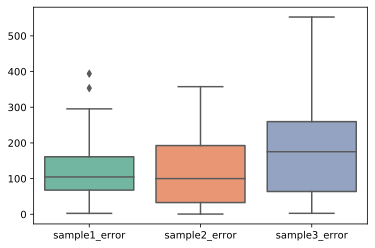

In [27]:
sns.boxplot(data=inaccuracy, palette='Set2')
plt.show()

*По предварительной оценке ошибки Sample1 и Sample2 не отличаются друг от друга по качеству. <br>
Но Sample3 статистически значимо отличается от Sample1 и Sample2. Проверим, используя стат критерии. <br>
Сначала выясним какие критерии нам нужно использовать - параметрические или непараметрические.*

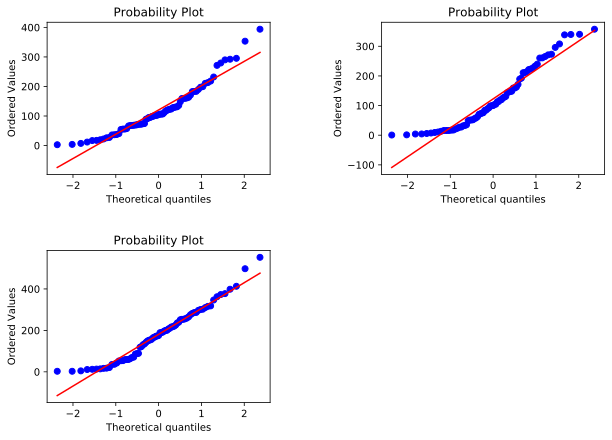

In [28]:
fig = plt.figure(figsize=(10, 7))

plt.subplot(221)
probplot(inaccuracy['sample1_error'], plot=plt)

plt.subplot(222)
probplot(inaccuracy['sample2_error'], plot=plt)

plt.subplot(223)
probplot(inaccuracy['sample3_error'], plot=plt)

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

*По рисункам сложно сказать, какое из распределений является нормальным. Рассчитаем критерий <br>
Шапиро-Уилка.*

In [29]:
print(shapiro(inaccuracy['sample1_error']))
print(shapiro(inaccuracy['sample2_error']))
print(shapiro(inaccuracy['sample3_error']))

ShapiroResult(statistic=0.9270203113555908, pvalue=0.0002756995672825724)
ShapiroResult(statistic=0.918087363243103, pvalue=0.00010489486157894135)
ShapiroResult(statistic=0.9572394490242004, pvalue=0.011136190965771675)


*Исходя из теста Шапиро-Уилка ни одно из распределений не является нормальным. <br>
Следовательно, для сравнения выборок (sample1_error, sample2_error и sample3_error) <br>
будем использовать непараметрический критерий Манна-Уитни.*

#### Sample1 и Sample2

In [30]:
mannwhitneyu(inaccuracy['sample1_error'], inaccuracy['sample2_error'])

MannwhitneyuResult(statistic=2864.0, pvalue=0.3589170477065957)

*Так как p-value > 0.05, мы не можем отвергнуть гипотезу о том, что между двумя выборками нет различий*

#### Sample1 и Sample3

In [31]:
mannwhitneyu(inaccuracy['sample1_error'], inaccuracy['sample3_error'])

MannwhitneyuResult(statistic=2148.0, pvalue=0.0015957916304683401)

*Так как p-value < 0.05, мы можем сделать вывод, что качество Sample_1 и Sample_3 не равны. <br>
Из графика видно, что качество Sample_1 выше Sample_3.*

#### Sample2 и Sample3

In [35]:
mannwhitneyu(inaccuracy['sample2_error'], inaccuracy['sample3_error'])

MannwhitneyuResult(statistic=2158.0, pvalue=0.0017926194941075208)

*Так как p-value < 0.05, мы можем сделать вывод, что качество Sample_2 и Sample_3 не равны. <br>
Из графика видно, что качество Sample_2 выше Sample_3.*

*В датасете* **OpenPart** *рассматривается еще один параметр правильности работы ML-модели - <br>
оценка эксперта. Интересно будет провести такой же статистический анализ на этих данных и <br>
полученные результаты с полученными выше. Если взаимосвязи такие же, то можно выдвинуть <br>
предположение об эквивалентности параметров 'расстояние между точками' - 'оценка эксперта'. <br>
Это хорошо тем, что в дальнейшем можно будет сэкомить деньги и время, и не опрашивать врача, а <br>
сразу в датасете рассчитать правильность работы ML-модели.*

In [32]:
grades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Case      60 non-null     object
 1   Sample 1  60 non-null     int64 
 2   Sample 2  60 non-null     int64 
 3   Sample 3  60 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 2.0+ KB


*Убираем дубли.*

In [37]:
grades = grades.drop_duplicates()
grades.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Case      60 non-null     object
 1   Sample 1  60 non-null     int64 
 2   Sample 2  60 non-null     int64 
 3   Sample 3  60 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 2.3+ KB


*Дублей нет. Проведем тот же статистический анализ, что и джля датафрейма* **inaccuracy**.

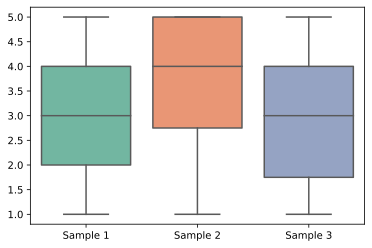

In [38]:
sns.boxplot(data=grades, palette='Set2')
plt.show()

*Рисунок отличается от раннее полученного. По нему можно предположить, что качество <br>
моделей Sample1 и Sample2 не отличается друг от друга, а качество модели Sample3 <br>
отличается как от Sample1, так и от Sample2. Проверим на цифрах.<br>
Так как в данном датафрейме переменные категориальные, то используем дисперсионныйц анализ.*

In [42]:
f_oneway(grades['Sample 1'], grades['Sample 2'], grades['Sample 3'])

F_onewayResult(statistic=3.9315975286849087, pvalue=0.021348571495090365)

*Можно сделать вывод, что имеется статистически значимое различие между группами (p-value < 0.05)*